# **Import Library**

In [9]:
import gdown
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

# **Data Loading**

In [11]:
url = 'https://drive.google.com/uc?id=1hWMo3PDw7DW2u3P0DnOSm4bS62Uzb6QJ'
output = 'student_performance.csv'

gdown.download(url, output, quiet=False)

data = pd.read_csv(output)

data.head()

Downloading...
From: https://drive.google.com/uc?id=1hWMo3PDw7DW2u3P0DnOSm4bS62Uzb6QJ
To: /content/student_performance.csv
100%|██████████| 36.0k/36.0k [00:00<00:00, 46.3MB/s]


,Socioeconomic Score,Study Hours,Sleep Hours,Attendance (%),Grades
0,0.95822,3.4,8.2,53.0,47.0
1,0.85566,3.2,5.9,55.0,35.0
2,0.68025,3.2,9.3,41.0,32.0
3,0.25936,3.2,8.2,47.0,34.0
4,0.60447,3.8,10.0,75.0,33.0


# **Exploratory Data Analysis**

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1388 entries, 0 to 1387
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Socioeconomic Score  1388 non-null   float64
 1   Study Hours          1388 non-null   float64
 2   Sleep Hours          1388 non-null   float64
 3   Attendance (%)       1388 non-null   float64
 4   Grades               1388 non-null   float64
dtypes: float64(5)
memory usage: 54.3 KB


In [13]:
data.describe()

,Socioeconomic Score,Study Hours,Sleep Hours,Attendance (%),Grades
count,1388.000000,1388.000000,1388.000000,1388.000000,1388.000000
mean,0.552274,4.560807,8.047262,58.536023,40.691643
std,0.261272,1.897581,1.370700,11.675287,9.467358
min,0.101280,0.800000,4.800000,40.000000,32.000000
25%,0.322118,3.475000,7.000000,49.000000,34.000000
50%,0.545945,3.900000,8.400000,57.000000,35.000000
75%,0.789610,5.900000,9.100000,66.000000,47.000000
max,0.999820,10.000000,10.000000,100.000000,91.000000


In [14]:
# Check for missing values
missing_values = data.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 Socioeconomic Score    0
Study Hours            0
Sleep Hours            0
Attendance (%)         0
Grades                 0
dtype: int64


In [15]:
# Check for invalid values
def check_invalid_values(column):
    return (data[column] <= 0).sum()

invalid_study_hours = check_invalid_values('Study Hours')
invalid_sleep_hours = check_invalid_values('Sleep Hours')
invalid_attendance = check_invalid_values('Attendance (%)')

print("Invalid Study Hours: ", invalid_study_hours)
print("Invalid Sleep Hours: ", invalid_sleep_hours)
print("Invalid Attendance: ", invalid_attendance)

Invalid Study Hours:  0
Invalid Sleep Hours:  0
Invalid Attendance:  0


<Axes: xlabel='Study Hours'>

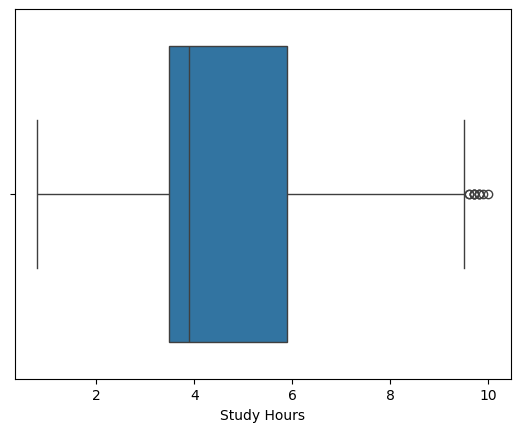

In [17]:
# Visualize distribution of features
sns.boxplot(x=data['Study Hours'])

<Axes: xlabel='Sleep Hours'>

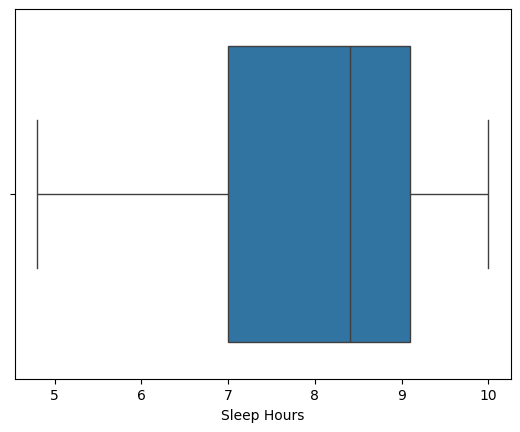

In [18]:
sns.boxplot(x=data['Sleep Hours'])

<Axes: xlabel='Attendance (%)'>

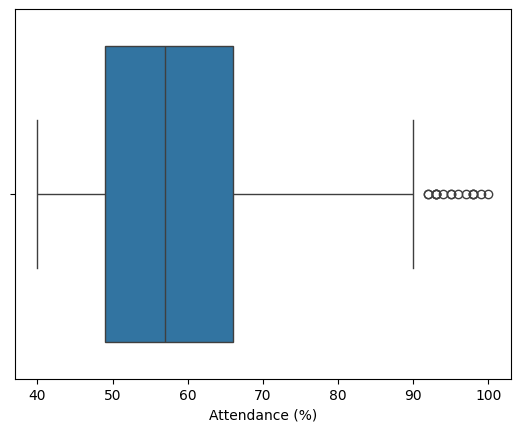

In [19]:
sns.boxplot(x=data['Attendance (%)'])

In [21]:
# Identify outliers using IQR method
numeric_features = ['Study Hours', 'Sleep Hours', 'Socioeconomic Score', 'Attendance (%)', 'Grades']
Q1 = data[numeric_features].quantile(0.25)
Q3 = data[numeric_features].quantile(0.75)
IQR = Q3 - Q1
data_cleaned = data[~((data[numeric_features] < (Q1 - 1.5 * IQR)) | (data[numeric_features] > (Q3 + 1.5 * IQR))).any(axis=1)]

print("Shape after removing outliers:", data_cleaned.shape)

Shape after removing outliers: (1342, 5)


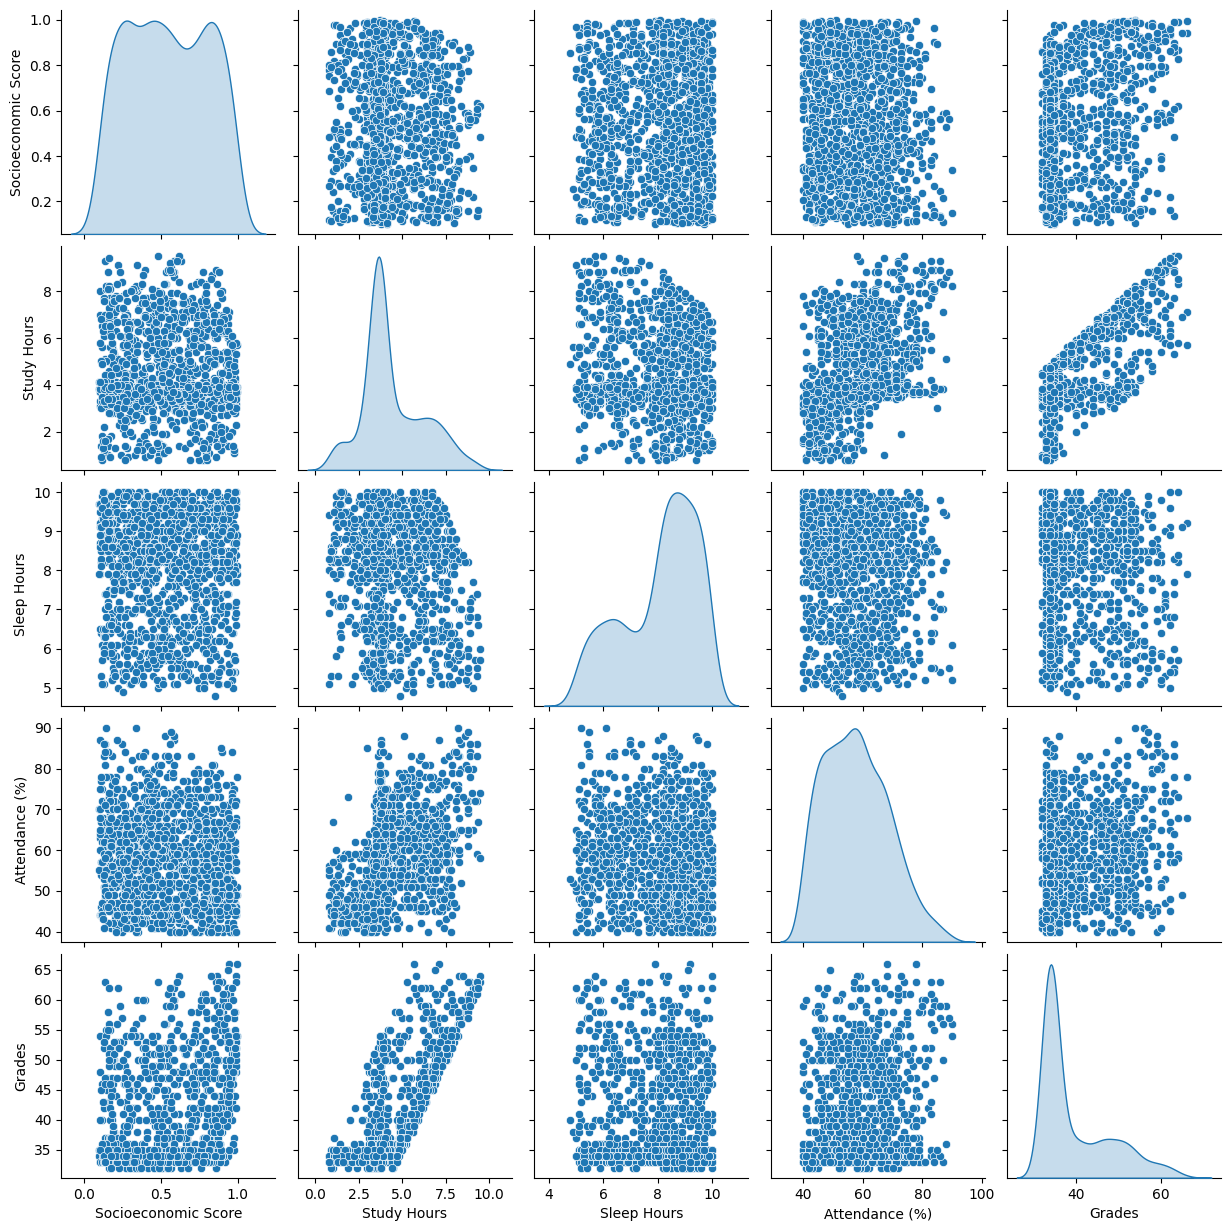

In [23]:
# Visualize relationships
sns.pairplot(data_cleaned, diag_kind='kde')

Text(0.5, 1.0, 'Correlation Matrix for Numeric Features')

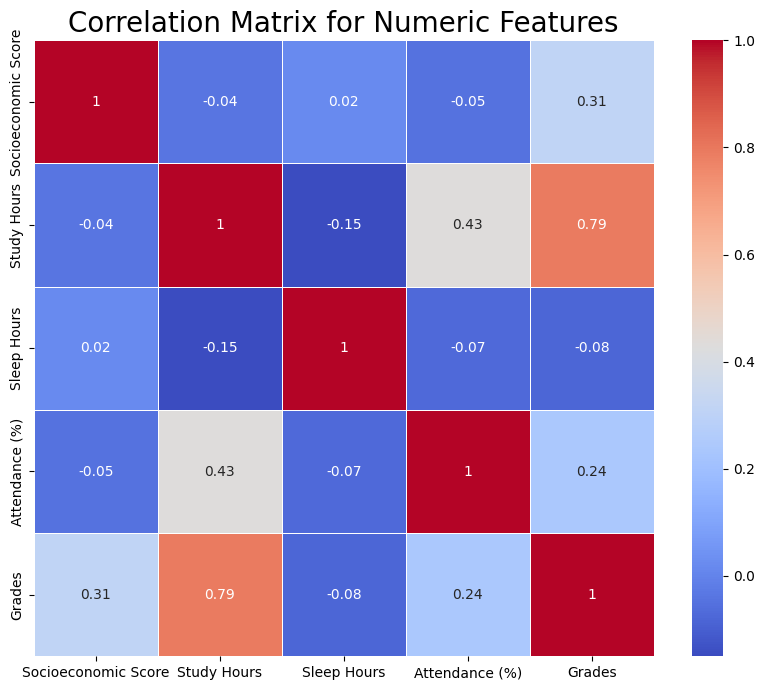

In [24]:
plt.figure(figsize=(10, 8))
correlation_matrix = data_cleaned.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix for Numeric Features", size=20)

# **Data Preparation**

In [26]:
# Prepare data for modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = data_cleaned.drop(["Grades"], axis=1)
y = data_cleaned["Grades"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print(f'Total samples in dataset: {len(X)}')
print(f'Samples in training set: {len(X_train)}')
print(f'Samples in test set: {len(X_test)}')

Total samples in dataset: 1342
Samples in training set: 1207
Samples in test set: 135


In [27]:
# Standardize numeric features
scaler = StandardScaler()
numeric_features = ['Study Hours', 'Sleep Hours', 'Socioeconomic Score', 'Attendance (%)']
scaler.fit(X_train[numeric_features])
X_train[numeric_features] = scaler.transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

In [28]:
# Train models and evaluate performance
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

models = pd.DataFrame(index=['train_mse', 'test_mse'], columns=['KNN', 'RandomForest', 'Boosting'])

# **Model Development**

In [29]:
# KNN Regressor
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)
models.loc['train_mse', 'KNN'] = mean_squared_error(y_pred=knn.predict(X_train), y_true=y_train)
models.loc['test_mse', 'KNN'] = mean_squared_error(y_pred=knn.predict(X_test), y_true=y_test)

In [30]:
# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
models.loc['train_mse', 'RandomForest'] = mean_squared_error(y_pred=rf.predict(X_train), y_true=y_train)
models.loc['test_mse', 'RandomForest'] = mean_squared_error(y_pred=rf.predict(X_test), y_true=y_test)

In [31]:
# AdaBoost Regressor
boosting = AdaBoostRegressor(n_estimators=50, learning_rate=0.1, random_state=42)
boosting.fit(X_train, y_train)
models.loc['train_mse', 'Boosting'] = mean_squared_error(y_pred=boosting.predict(X_train), y_true=y_train)
models.loc['test_mse', 'Boosting'] = mean_squared_error(y_pred=boosting.predict(X_test), y_true=y_test)

In [32]:
# Display MSE for all models
print(models)

                KNN RandomForest  Boosting
train_mse  3.381574     0.232899  3.736187
test_mse   5.782815     1.723313  6.746766


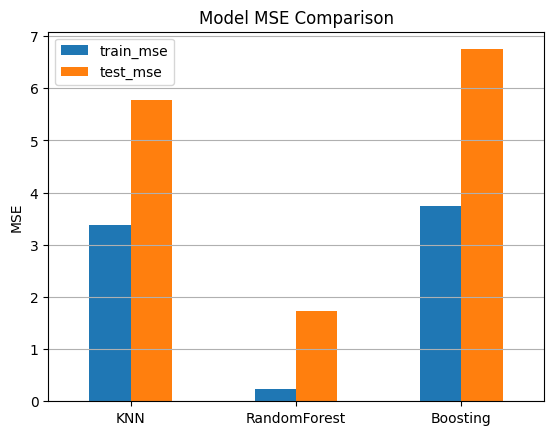

In [33]:
# Visualize MSE comparison
fig, ax = plt.subplots()
models.T.plot(kind='bar', ax=ax)
plt.title('Model MSE Comparison')
plt.ylabel('MSE')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

# **Testing**

In [34]:
# Prediction example
pred = X_test.iloc[:1]
predictions = {'y_true': y_test.iloc[:1]}
for name, model in {'KNN': knn, 'RandomForest': rf, 'Boosting': boosting}.items():
    predictions[f'pred_{name}'] = model.predict(pred).round(2)
pd.DataFrame(predictions)

,y_true,pred_KNN,pred_RandomForest,pred_Boosting
821,34.0,34.2,33.86,34.51
